In [212]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [213]:
def f(x):
    return 3*x**2 -4*x + 5

In [214]:
f(3.0)

20.0

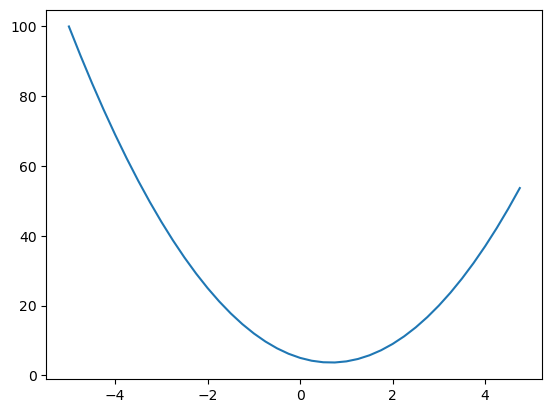

In [215]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [216]:
h = 0.00001
x = 2/3
(f(x+h) - f(x)) / h

3.0000002482211127e-05

In [217]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

4.0

In [218]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.

d1 = a*b + c
c += h 
d2 = a*b + c

print(d1)
print(d2)
print('slope', (d2 - d1) / h)

4.0
4.0001
slope 0.9999999999976694


In [219]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += (other * self.data**(other -1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self + other


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0 , label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0 , label='f')
L = d * f; L.label='L'
L

Value(data=-8.0)

In [220]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')

a-b

Value(data=5.0)

In [221]:
L._op

'*'

In [222]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

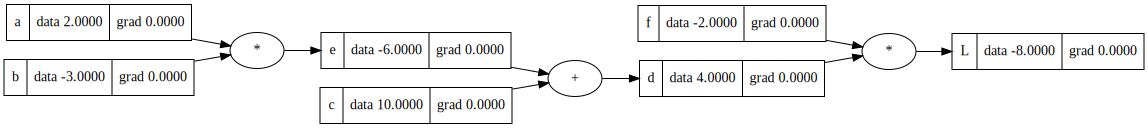

In [223]:
draw_dot(L)

L = d * f
dL/dd = ?

(f(x+h) - f(x)) / h

((d+h) * f - d * f) / h
(d*f + h*f - d*f) / h
(h*f) / h
f

(Çapraz kuralı)

dL / dc (c, d üzerinden, L yi nasıl etkiliyor?)


dd / dc? 1.0
dd / de? 1.0 (simetriden)

d = c + e 
(f(x+h) - f(x)) / h - Definition of derivative

((c + h + e) - (c + e)) / h
(c + h + e - c - e) / h
h/h
1

c d'yi nasıl etkiliyor biliyoruz
e d'yi nasıl etkiliyor biliyoruz
ama c ve e L yi nasıl etkiliyor? -Chain Rule

h'(x) = f'(g(x))g'(x)

dz/dx = dz/dy * dy/dx yani c'nin d'yi etkileyişiyle d'nin L'yi etkileyişini çarparsak c'nin L'li nasıl etkilediğini buluruz.

WANT:
dL / dc = (dl / dd) * (dd / dc)

KNOW:
dL / dd
dd / dc

dL / de = 2.0 
dL / da = (dL / de) * (de / da)

e = a * b

de / da ? -> b

In [224]:
a.data += 0.001 * a.grad
b.data += 0.001 * b.grad
c.data += 0.001 * c.grad
f.data += 0.001 * f.grad

e = a * b
d = e + c
L = d * f
print(L.data)

-8.0


In [225]:
a.grad = (-2.0) * (-3.0)
b.grad = (-2.0) * (2.0)

In [226]:
c.grad = -2.0
e.grad = -2.0

In [227]:
f.grad = 4.0
d.grad = -2.0

In [228]:
L.grad = 1.0

In [229]:
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0 , label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0 , label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0 , label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2-L1) / h)

In [230]:
lol()

-4.000000000008441


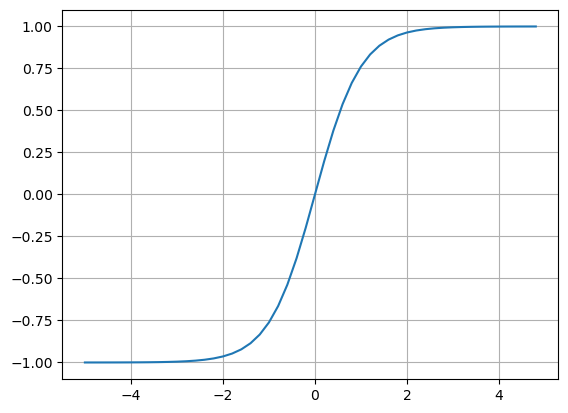

In [231]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [232]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

#x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
o.backward()

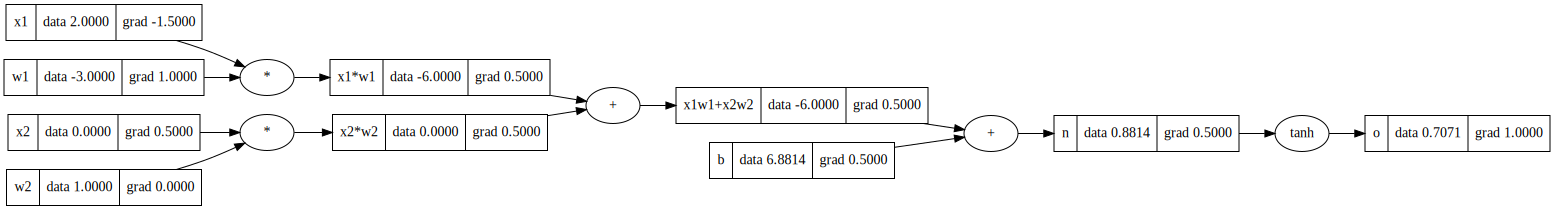

In [233]:
draw_dot(o)

In [234]:
o.backward()

In [235]:
#topological sort - Important!!

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [236]:
o.grad = 1.0

In [237]:
o._backward()

In [238]:
n._backward()

In [239]:
b._backward()

In [240]:
x1w1x2w2._backward()

In [241]:
x2w2._backward()
x1w1._backward()

In [242]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [243]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [244]:
x1w1.grad = (1 - o.data**2) * 1.0 * 1.0
x2w2.grad = (1 - o.data**2) * 1.0 * 1.0

In [245]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [246]:
n.grad = 0.5

In [247]:
o.grad = 1.0

In [248]:
1- o.data**2

0.4999999999999999

In [249]:
# o = tanh(n)
# do / dn = 1 - o**2

Burda neden tanh kullandık?

Tanh(hyperbolic tangent), sigmoid ve relu(rectified linear unit) bunlar aktivasyon fonksiyonlarıdır. Nöron aktive edilmeli mi edilmemeli mi ona karar verir. Nöronun outputunnu lineerlikten çıkarır yani lineer regresyon gibi dümdüz bi çizgi çizmemek için kullanıyoruz bi yandan. Layerların da bi anlamı olmuyor o zaman çünkü  üst üste konulduğunda zaten aynı sonuç gelecek 2(3x), 6x demektir ve hala lineer. Aktivasyon fonksiyonuyla non-linear(eğrilik barındıran) çizgiler çizebiliriz. 

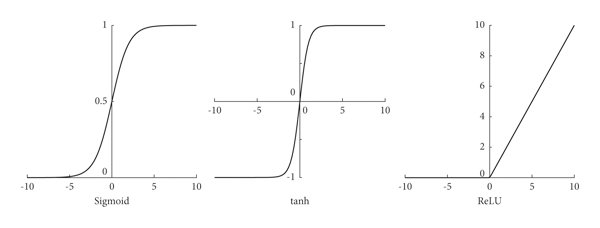

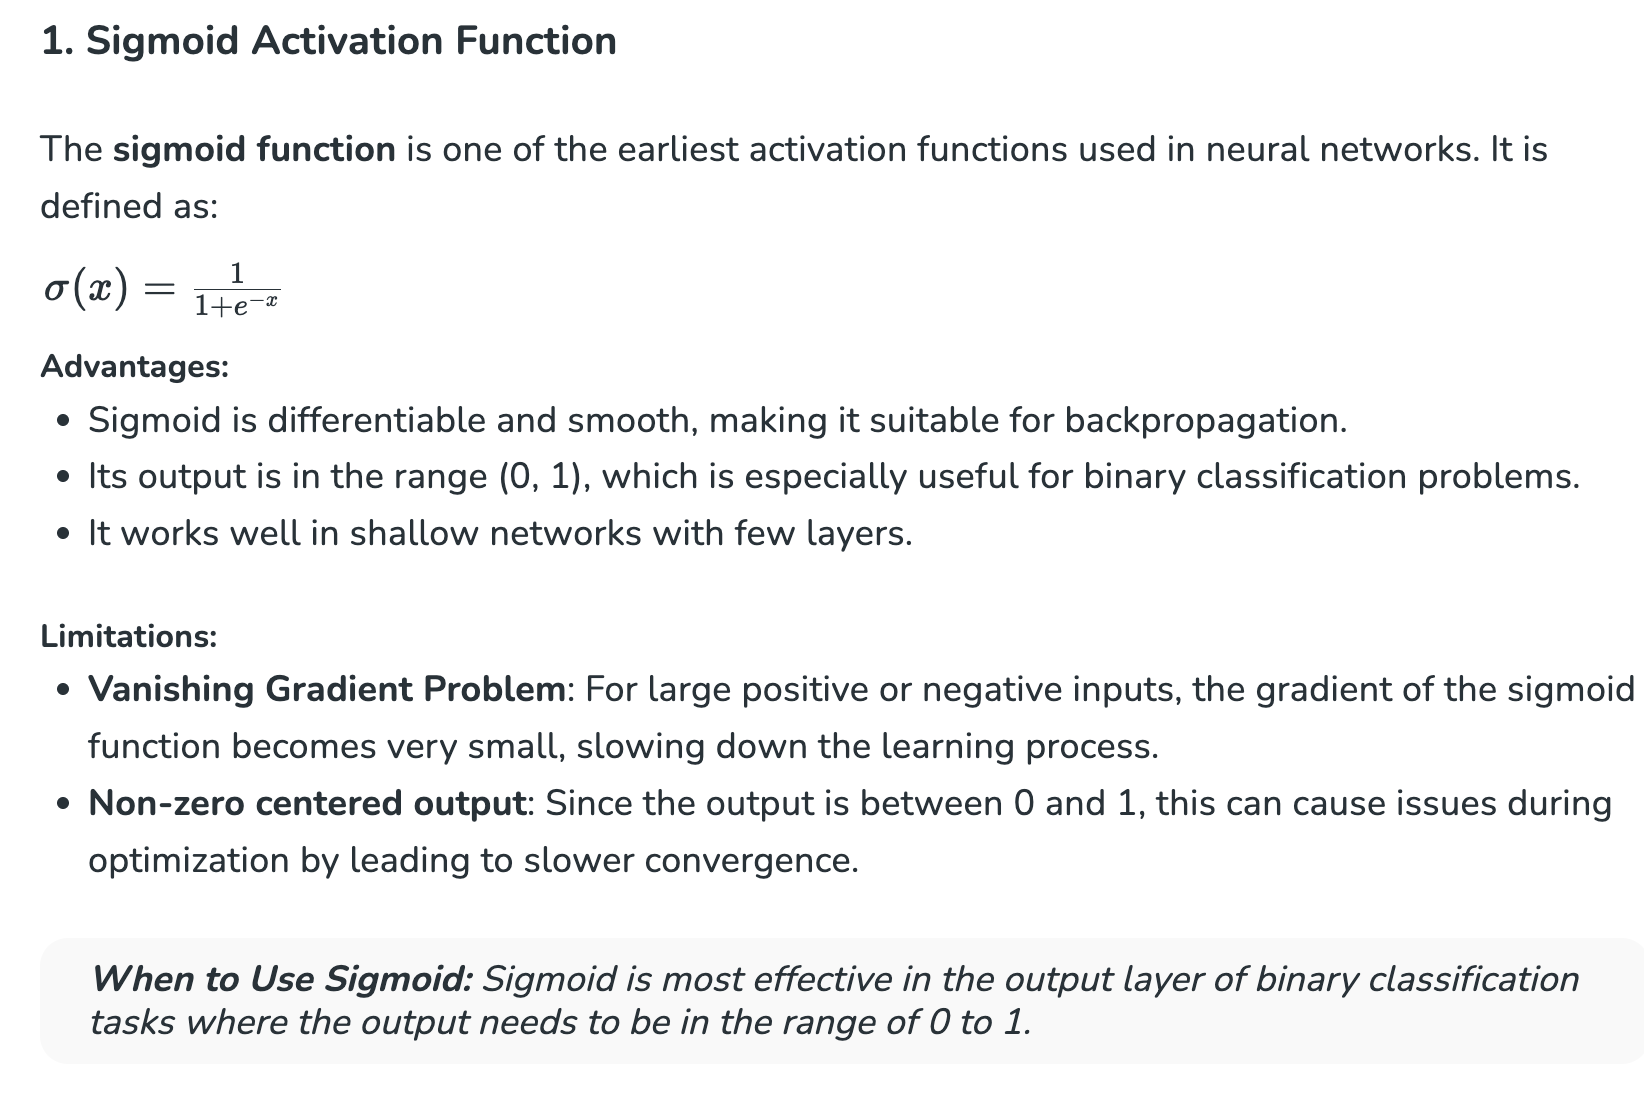

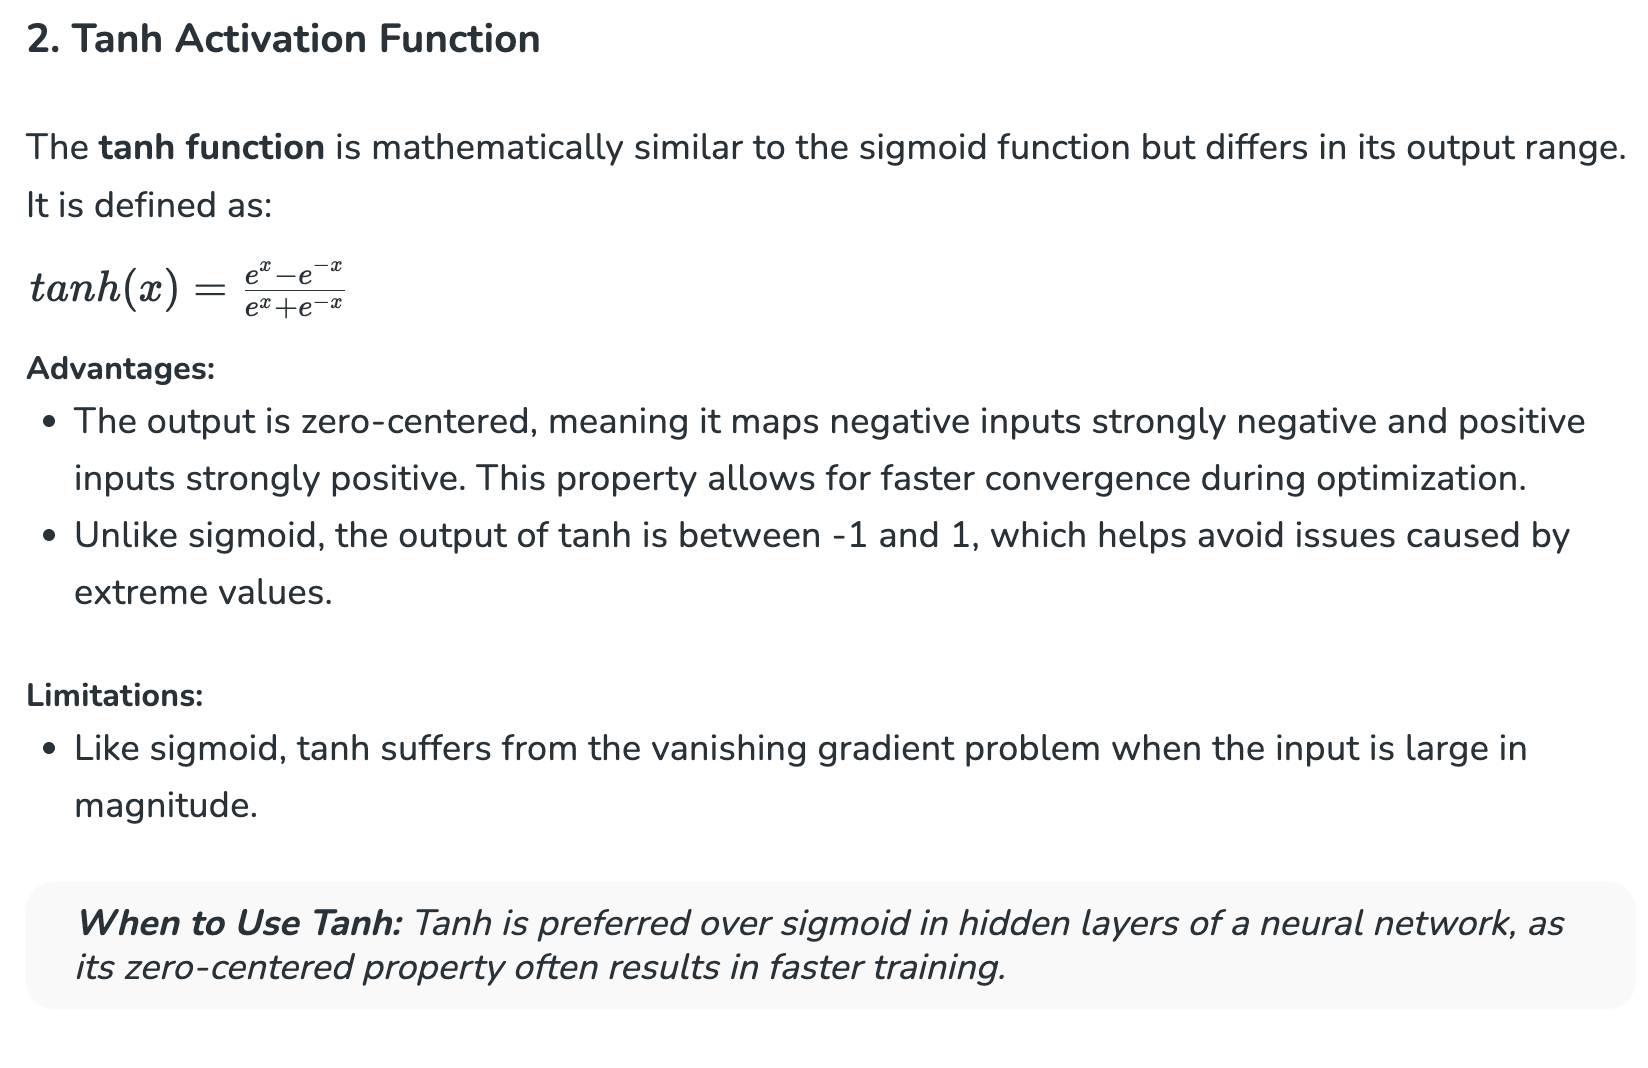

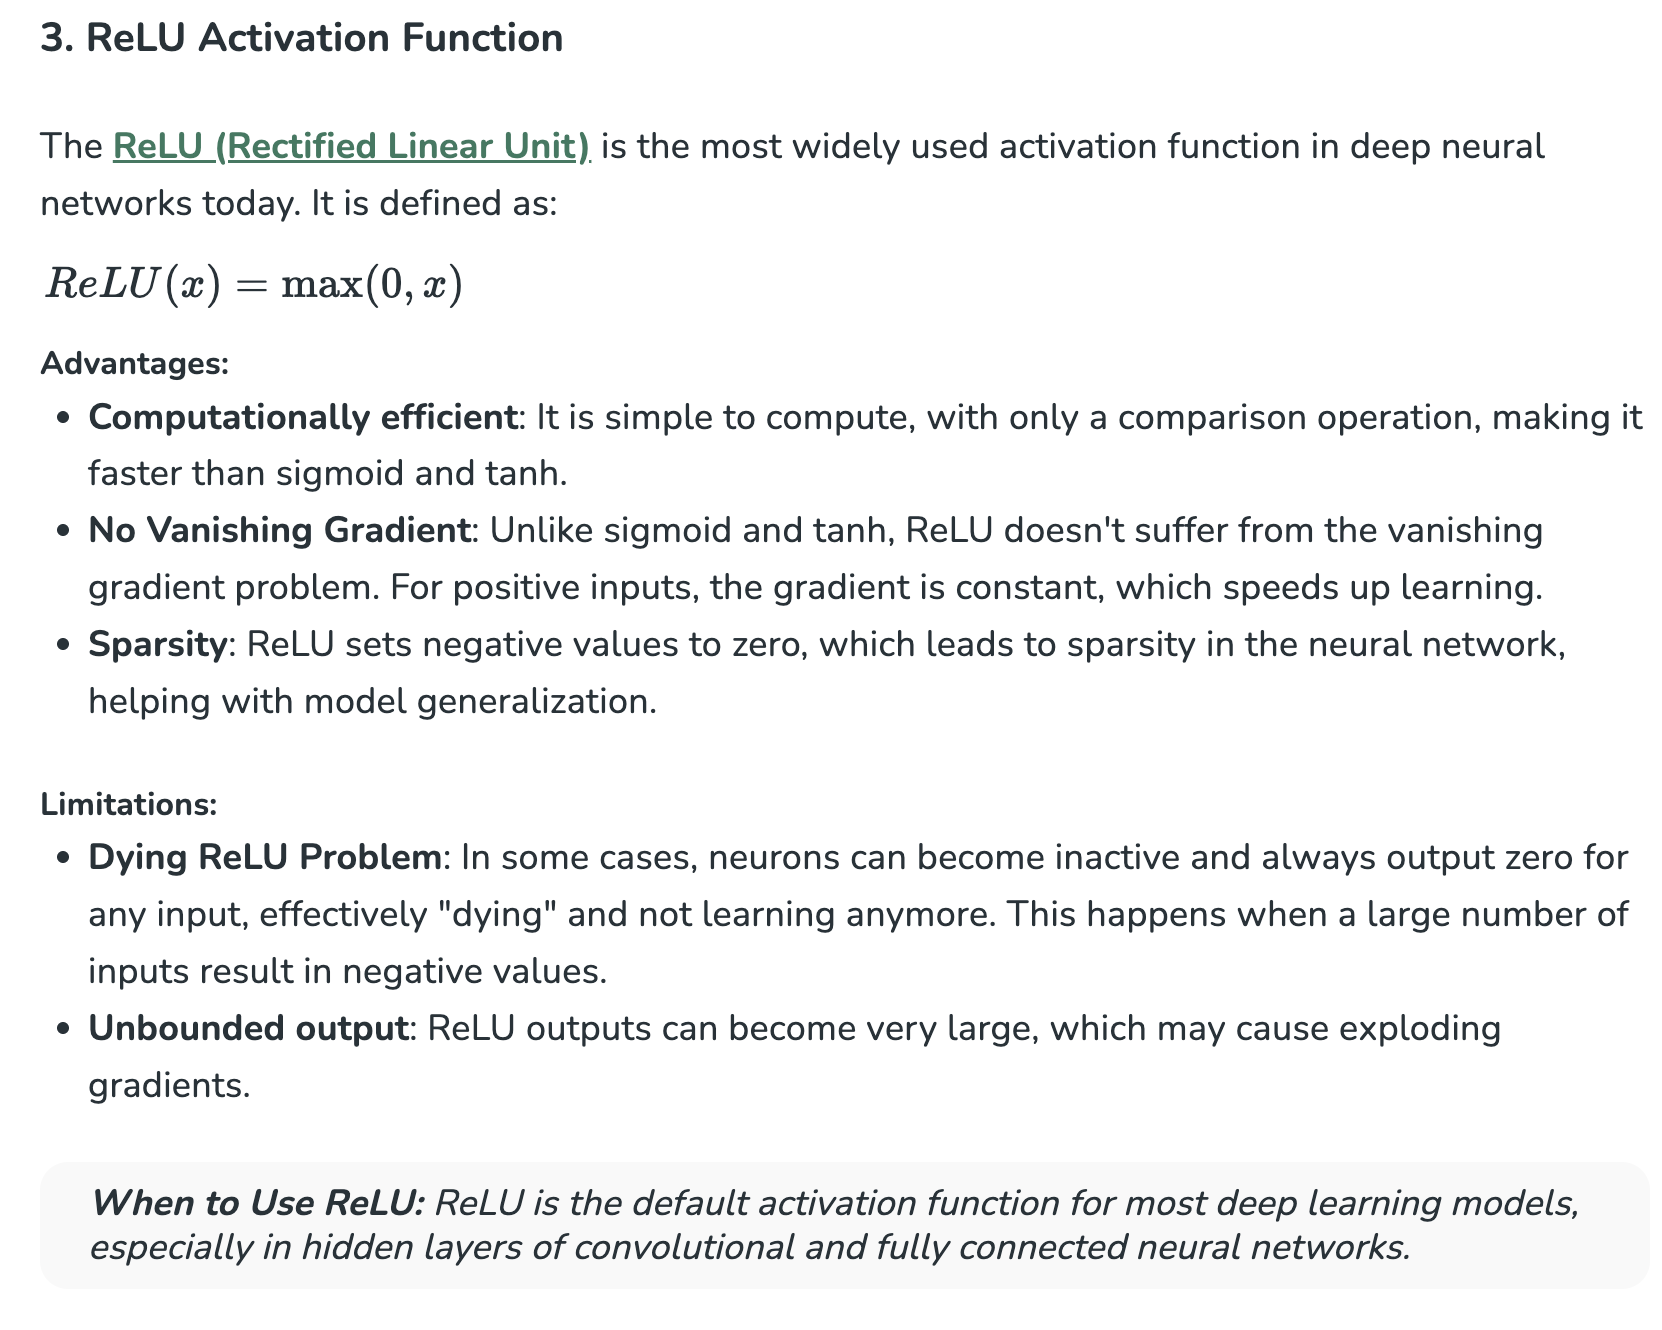

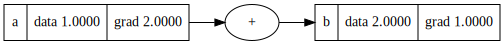

In [250]:
a = Value(1.0, label='a')
b = a + a ; b.label='b'
b.backward()
draw_dot(b)

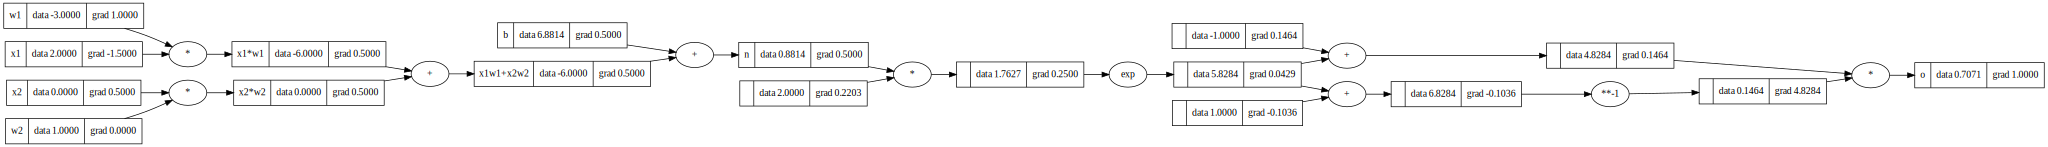

In [251]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

#x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b; n.label = 'n'

#o = n.tanh(); o.label = 'o'
e = (2*n).exp()
o = (e - 1) / (e + 1); o.label = 'o'

o.backward()
draw_dot(o)

In [252]:
import torch
x1 = torch.tensor([2.0]).double().requires_grad_(True)
x2 = torch.tensor([0.0]).double().requires_grad_(True)
w1 = torch.tensor([-3.0]).double().requires_grad_(True)
w2 = torch.tensor([1.0]).double().requires_grad_(True)
b = torch.tensor([6.8813735870195432]).double().requires_grad_(True)
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-----')
print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())

0.7071066904050358
-----
-1.5000003851533106
0.5000001283844369
1.0000002567688737
0.0


In [253]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] 
        self.b = Value(np.random.uniform(-1,1))
    
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [299]:
x = [2.0, 3.0, -1]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.7178781973658355)

In [300]:
xs = [
[2.0, 3.0, -1.0],
[3.0, -1.0, 0.5],
[0.5, 1.0, 1.0],
[1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [322]:
for k in range(20):

    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)


0 0.002350329456945957
1 0.002342527941927918
2 0.0023347770786866706
3 0.0023270763795504553
4 0.002319425363058062
5 0.0023118235538603996
6 0.0023042704826242554
7 0.002296765685937679
8 0.0022893087062172517
9 0.0022818990916169176
10 0.0022745363959387446
11 0.002267220178545176
12 0.0022599500042729346
13 0.0022527254433486466
14 0.002245546071305754
15 0.0022384114689032964
16 0.0022313212220458254
17 0.0022242749217051107
18 0.002217272163842971
19 0.002210312549335781


In [323]:
ypred

[Value(data=0.9773317365797156),
 Value(data=-0.9772822904045896),
 Value(data=-0.9760214054112697),
 Value(data=0.9753952229204919)]

In [268]:
loss.backward()

In [269]:
n.layers[0].neurons[0].w[0].data

-0.029490571110282887

In [270]:
for p in n.parameters():
    p.data += -0.01 * p.grad        

In [271]:
n.layers[0].neurons[0].w[0].data

-0.03232198825894274

In [272]:
ypred

[Value(data=-0.9695652667288736),
 Value(data=-0.9644710842580119),
 Value(data=-0.973752874079994),
 Value(data=-0.9777597209658865)]

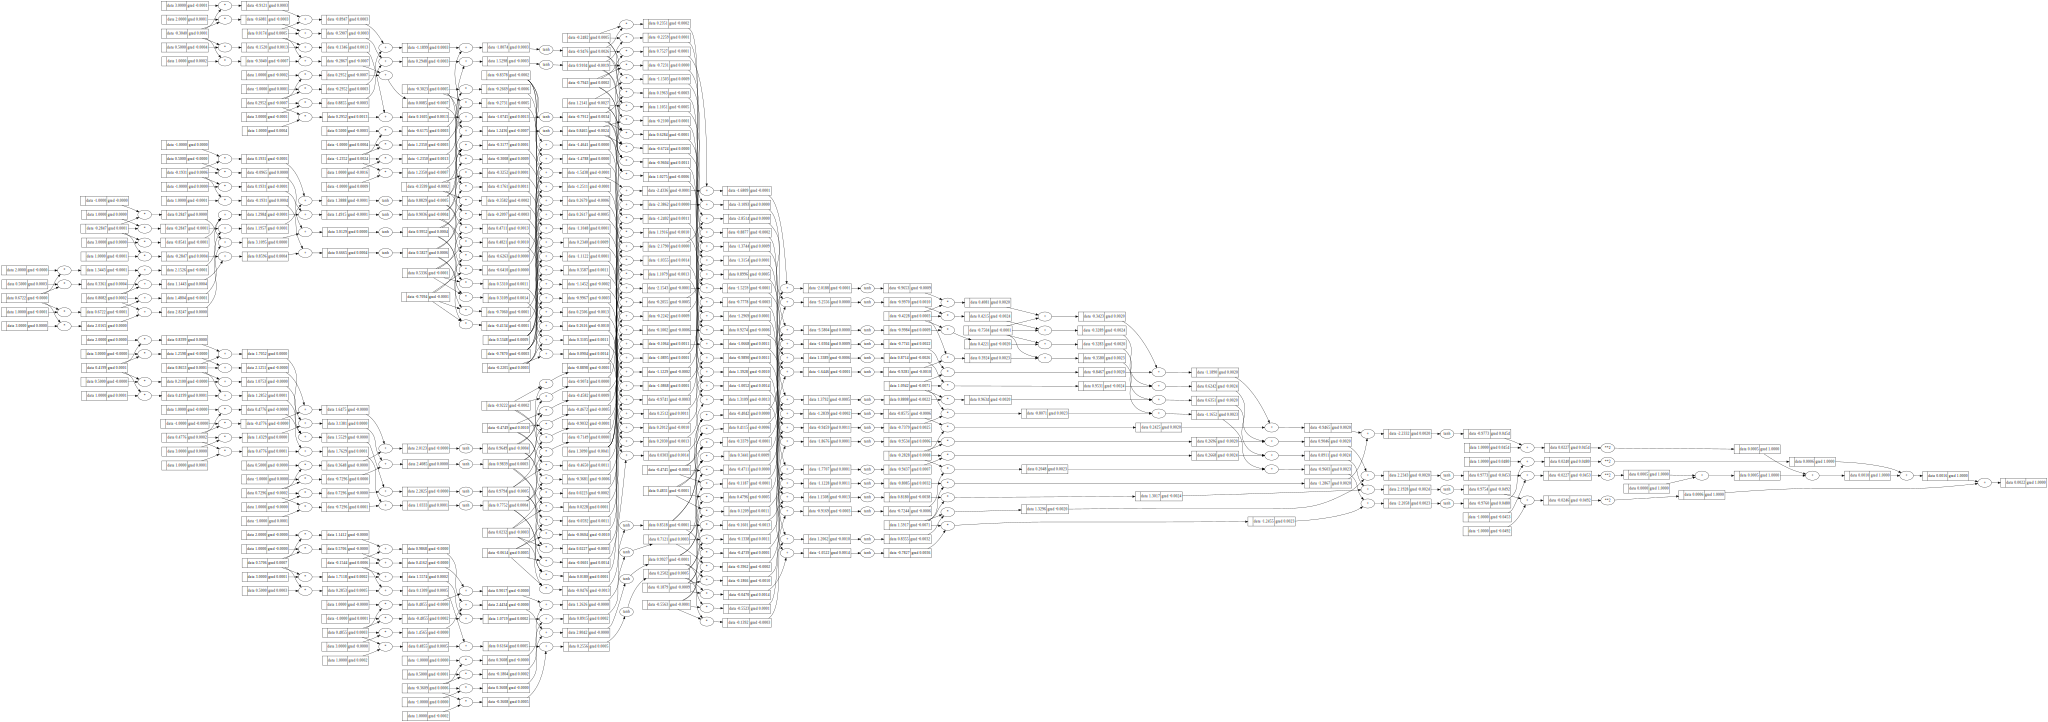

In [324]:
draw_dot(loss)